In [108]:
# set working directory (location where code is)
import os
import re
import csv
import time
import pandas as pd
import numpy as np
from PIL import Image
from random import randint
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
 
# set gmail credentials and path to extract data
google_username = "wanghou92@gmail.com"
google_password = "x@wk9K64"

pytrends = TrendReq(hl='en-US', tz=360)

In [471]:
## import btc price series
import pickle
import quandl
from datetime import datetime
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
quandl.ApiConfig.api_key = 'xP8VfHsz4zyssuf2MX8y'

In [472]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [473]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


In [503]:
def selectPeriod(dataframe, start_year = 2017, start_month = 1,start_date = 1, end_year = 2017,end_month = 1,end_date = 1):
    assert end_year >= start_year
    df = dataframe[str(start_year)+"-"+str(start_month)+"-"+str(start_date):str(end_year)+"-"+str(end_month)+"-"+str(end_date)]
#     df = dataframe[(dataframe.index.year >= start_year) & (dataframe.index.year <= end_year)]
#     df = df[(df.index.month >= start_month) & (df.index.month <= end_month)]
    return df

In [475]:
# Chart the BTC pricing data
btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
#py.iplot([btc_trace])

In [476]:
# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [477]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [478]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [479]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [480]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

In [481]:
# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

In [482]:
# slice time
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace])

#### Below is the utility to generate word cloud:

In [349]:
# generate words for wordcoud
def raw_words_generator(words, values, keyword, weight=5):
    text = ""
    for i in range(len(values)):
        if(values[i] == 0):
            for j in range(values[i] + 3):
                    text += (str(words[i].replace(keyword.lower(), "")) + " ")
        else:
            for j in range(values[i]):
                    text += (str(words[i].replace(keyword.lower(), "")) + " ")*weight
    return text

In [304]:
## Question 1: interest on bitcoin - April 7 - April 13, 2013
# payload: 
def payLoadBuider(keywords, start_time, end_time):
    kw_list = keywords
    catego = 0 # finance category
    start_time = start_time
    end_time = end_time
    time = start_time+" "+end_time;
    return pytrends.build_payload(kw_list, cat=catego, timeframe=time, geo='', gprop='')

In [352]:
def wordCloudGenerator(val, wd, cloud_mask="mask-cloud.png", color="white",title=None):
        '''
        val: np array of weights
        wd: np array of words
        '''
        values = val 
        words = wd 
        read_from_file = open('words.txt').read()
        random.shuffle(read_from_file.lstrip().split())
        random_words = "".join(read_from_file[2000:22000])
        # print(random_words)
        ## text generator
        test = raw_words_generator(words, values, kw_list[0])
        text_to_be_used = test.split()
        random.shuffle(text_to_be_used)

        res = str(" ".join(text_to_be_used))
        res += random_words

        ## word cloud mask
        cloud_mask = np.array(Image.open("mask-cloud.png"))

        ## word cloud generator
        color="white"
        wordcloud = WordCloud(background_color=color, mask=cloud_mask).generate(res)
        fig = plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        if title != None:
            plt.title(title)
        plt.axis("off")
        plt.show()
        fig.savefig('./figures/'+title+'.png')

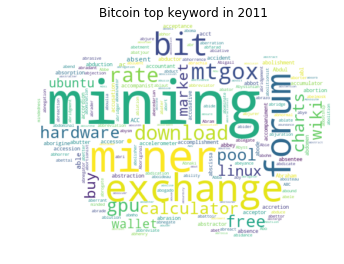

In [554]:
# query # query payload
kw_list = ["bitcoin"]
start_time = '2011-01-01'
end_time = '2011-12-31'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query[kw_list[0]]['top']['value']
words = related_query[kw_list[0]]['top']['query']
wordCloudGenerator(values, words,title="Bitcoin top keyword in 2011")

# price correaltion in 2011
# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2011, start_month = 1, end_year = 2011,end_month = 12)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace])

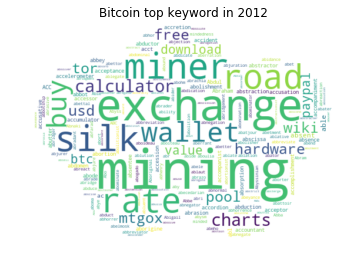

In [555]:
# query # query payload
kw_list = ["bitcoin"]
start_time = '2012-01-01'
end_time = '2012-12-31'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query[kw_list[0]]['top']['value']
words = related_query[kw_list[0]]['top']['query']
wordCloudGenerator(values, words,title="Bitcoin top keyword in 2012")
# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2012, start_month = 1, end_year = 2012,end_month = 12)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace])

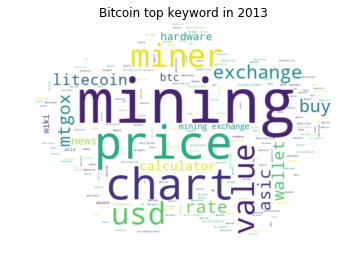

In [556]:
# query # query payload
kw_list = ["bitcoin"]
start_time = '2013-01-01'
end_time = '2013-12-31'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query[kw_list[0]]['top']['value']
words = related_query[kw_list[0]]['top']['query']
wordCloudGenerator(values, words,title="Bitcoin top keyword in 2013")

# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2013, start_month = 1, end_year = 2013,end_month = 12)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
df = selectPeriod(btc_usd_datasets, start_year = 2013, start_month = 11, start_date = 1, end_year = 2013,end_month = 12, end_date=5)
btc_trace2 = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace,btc_trace2])

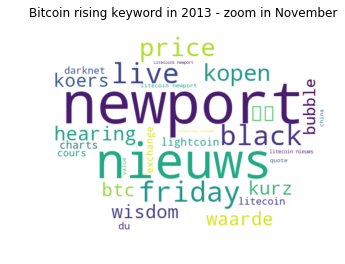

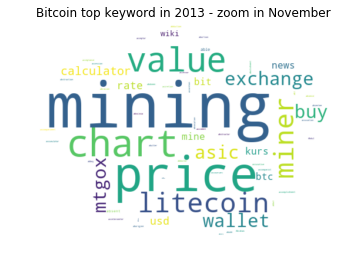

In [558]:
# query # query payload
kw_list = ["bitcoin"]
start_time = '2013-11-01'
end_time = '2013-12-05'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query[kw_list[0]]['rising']['value']
words = related_query[kw_list[0]]['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin rising keyword in 2013 - zoom in November")
values = related_query[kw_list[0]]['top']['value']
words = related_query[kw_list[0]]['top']['query']
wordCloudGenerator(values, words,title="Bitcoin top keyword in 2013 - zoom in November")

# slice time
df2 = selectPeriod(btc_usd_datasets, start_year = 2013, start_month = 10, start_date = 30, end_year = 2013,end_month = 12, end_date= 10)
btc_trace = go.Scatter(x=df2.index, y=df2['avg_btc_price_usd'])
df = selectPeriod(btc_usd_datasets, start_year = 2013, start_month = 11, start_date = 1, end_year = 2013,end_month = 12, end_date= 5)
btc_trace2 = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace,btc_trace2])

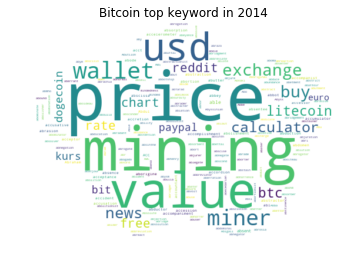

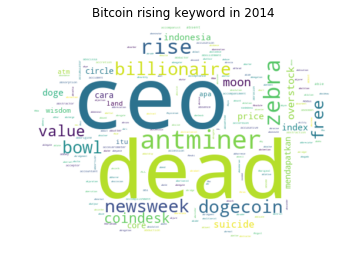

In [559]:
#payload builder
kw_list = ["Bitcoin"]
start_time = '2014-01-01'
end_time = '2014-12-31'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query['Bitcoin']['top']['value']
words = related_query['Bitcoin']['top']['query']
wordCloudGenerator(values, words,title="Bitcoin top keyword in 2014")

#payload builder
# word cloud utility# query payload
values = related_query['Bitcoin']['rising']['value']
words = related_query['Bitcoin']['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin rising keyword in 2014")
# https://nypost.com/2014/03/05/bitcoin-firm-ceo-found-dead-in-suspected-suicide/
# bitcoin ceo dead: bitcoin exchange firm First Meta

In [428]:
# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2014, start_month = 1, end_year = 2014,end_month = 12)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace])

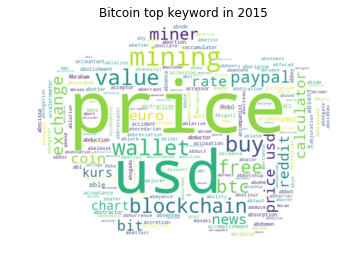

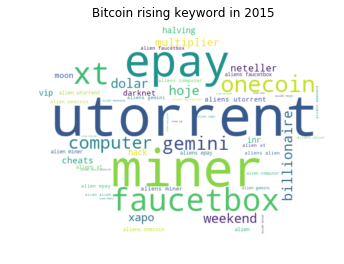

In [560]:
#payload builder
kw_list = ["Bitcoin"]
start_time = '2015-01-01'
end_time = '2015-12-31'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query['Bitcoin']['top']['value']
words = related_query['Bitcoin']['top']['query']
wordCloudGenerator(values, words,title="Bitcoin top keyword in 2015")

# word cloud utility# query payload
values = related_query['Bitcoin']['rising']['value']
words = related_query['Bitcoin']['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin rising keyword in 2015")

# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2015, start_month = 1, end_year = 2015,end_month = 12)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace])

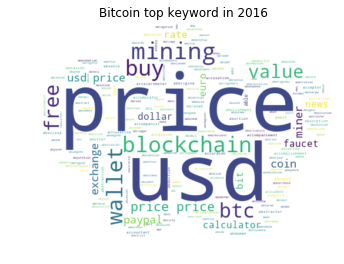

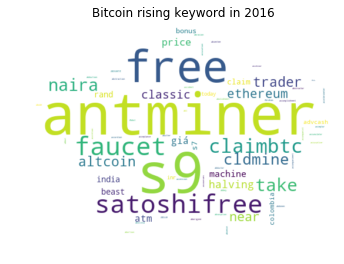

In [561]:
# query payload
kw_list = ["Bitcoin"]
start_time = '2016-01-01'
end_time = '2016-12-31'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query['Bitcoin']['top']['value']
words = related_query['Bitcoin']['top']['query']
wordCloudGenerator(values, words,title="Bitcoin top keyword in 2016")

# word cloud utility# query payload
values = related_query['Bitcoin']['rising']['value']
words = related_query['Bitcoin']['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin rising keyword in 2016")

In [434]:
# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2016, start_month = 1, end_year = 2016,end_month = 12)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace])

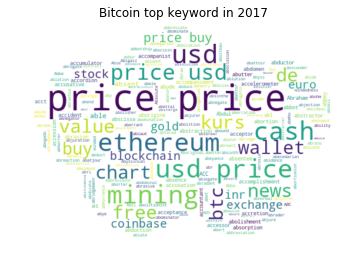

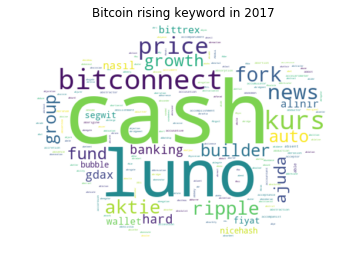

In [562]:
# query payload
kw_list = ["Bitcoin"]
start_time = '2017-01-01'
end_time = '2017-12-5'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query['Bitcoin']['top']['value']
words = related_query['Bitcoin']['top']['query']
wordCloudGenerator(values, words,title="Bitcoin top keyword in 2017")

# word cloud utility# query payload
values = related_query['Bitcoin']['rising']['value']
words = related_query['Bitcoin']['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin rising keyword in 2017")

In [601]:
# slice time
df6 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 11, start_date = 5, end_year = 2017,end_month = 12,end_date = 4)
btc_trace5 = go.Scatter(x=df6.index, y=df6['avg_btc_price_usd'],mode='markers',name='11/05/2017 - 12/04/2017')
df5 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 10, start_date=27, end_year = 2017,end_month = 11,end_date=5)
btc_trace4 = go.Scatter(x=df5.index, y=df5['avg_btc_price_usd'], name='10/27/2017 - 11/05/2017')
df4 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 10,start_date = 1, end_year = 2017,end_month = 10,end_date = 14)
btc_trace3 = go.Scatter(x=df4.index, y=df4['avg_btc_price_usd'], name='10/01/2017 - 10/14/2017')
df3 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 9, start_date = 1, end_year = 2017,end_month = 9,end_date=14)
btc_trace2 = go.Scatter(x=df3.index, y=df3['avg_btc_price_usd'],name='9/01/2017 - 09/14/2017')
df2 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 6, start_date=12, end_year = 2017,end_month = 7,end_date=17)
btc_trace1 = go.Scatter(x=df2.index, y=df2['avg_btc_price_usd'],mode='markers',name='06/12/2017 - 07/17/2017')
df = selectPeriod(btc_usd_datasets, start_year = 2016, start_month = 1, end_year = 2017,end_month = 12)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace,btc_trace1,btc_trace2,btc_trace3, btc_trace4, btc_trace5])

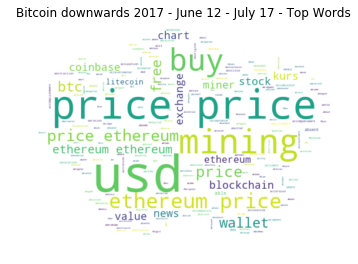

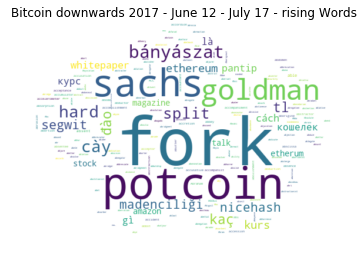

In [563]:
# query payload
kw_list = ["Bitcoin"]
start_time = '2017-06-12'
end_time = '2017-07-17'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query['Bitcoin']['top']['value']
words = related_query['Bitcoin']['top']['query']
wordCloudGenerator(values, words,title="Bitcoin downwards 2017 - June 12 - July 17 - Top Words")

# word cloud utility# query payload
values = related_query['Bitcoin']['rising']['value']
words = related_query['Bitcoin']['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin downwards 2017 - June 12 - July 17 - rising Words")
# https://www.coindesk.com/goldman-sachs-bearish-bitcoin-price/
# https://en.wikipedia.org/wiki/PotCoin

In [606]:
# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 6, start_date=12, end_year = 2017,end_month = 7,end_date=17)

btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
py.iplot([btc_trace])

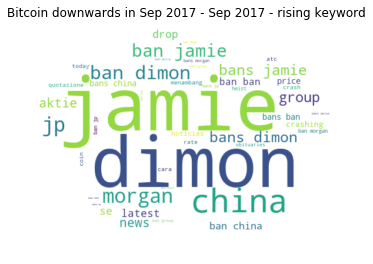

In [607]:
# query payload
kw_list = ["Bitcoin"]
start_time = '2017-09-01'
end_time = '2017-09-14'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query['Bitcoin']['rising']['value']
words = related_query['Bitcoin']['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin downwards in Sep 2017 - Sep 2017 - rising keyword")
# https://www.cnbc.com/video/2017/10/13/jpmorgan-ceo-jamie-dimon-i-could-care-less-about-bitcoin.html
# https://www.forbes.com/sites/kenrapoza/2017/10/18/chinas-blockchain-bitcoin-ban-no-match-for-stateless-cryptocurrency-market/#3b72b6402de6

In [532]:
# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 8,end_year = 2017,end_month = 10)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
df2 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 9, start_date = 1, end_year = 2017,end_month = 9,end_date=14)
btc_trace2 = go.Scatter(x=df2.index, y=df2['avg_btc_price_usd'])
py.iplot([btc_trace,btc_trace2])

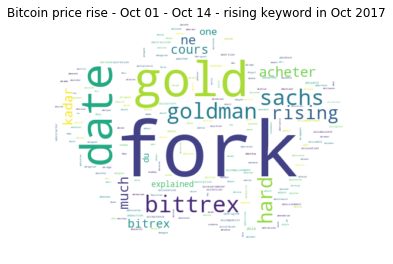

In [575]:
# query payload
kw_list = ["Bitcoin"]
start_time = '2017-10-01'
end_time = '2017-10-14'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query['Bitcoin']['rising']['value']
words = related_query['Bitcoin']['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin price rise - Oct 01 - Oct 14 - rising keyword in Oct 2017")


In [534]:
# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 9, start_date = 27, end_year = 2017,end_month = 11)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
df2 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 10,start_date = 1, end_year = 2017,end_month = 10,end_date = 14)
btc_trace2 = go.Scatter(x=df2.index, y=df2['avg_btc_price_usd'])
py.iplot([btc_trace,btc_trace2])

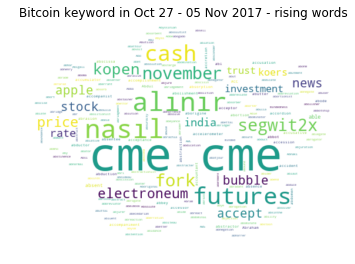

In [610]:
# query payload
kw_list = ["Bitcoin"]
start_time = '2017-10-27'
end_time = '2017-11-05'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query['Bitcoin']['rising']['value']
words = related_query['Bitcoin']['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin keyword in Oct 27 - 05 Nov 2017 - rising words")
# https://bitcoingold.org/ hard fok - bitcoin mining
# https://cointelegraph.com/news/cme-groups-regulated-futures-market-may-enable-retail-giants-to-accept-bitcoin
# liquidity of bitcoin increases, drive up the price

In [536]:
# slice time
df = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 10, start_date=18, end_year = 2017,end_month = 11, end_date=11)
btc_trace = go.Scatter(x=df.index, y=df['avg_btc_price_usd'])
df2 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 10, start_date=27, end_year = 2017,end_month = 11,end_date=5)
btc_trace2 = go.Scatter(x=df2.index, y=df2['avg_btc_price_usd'])
py.iplot([btc_trace,btc_trace2])

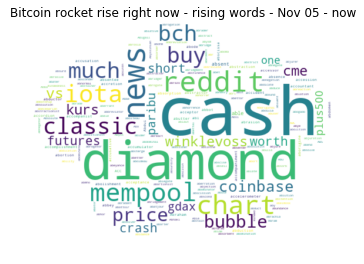

'\nBitcoin (BTC) has been the most popular cryptocurrency of its times. \nHowever, it is not free from its shortcomings. \nBTC transactions have been taking notoriously long time to process and they have gone expensive over time. \nThis is because BTC blocks have been limited to one megabyte in size, which translates into around three transactions per second.\n'

In [612]:
# query payload
kw_list = ["Bitcoin"]
start_time = '2017-11-05'
end_time = '2017-12-04'
payLoadBuider(kw_list,start_time,end_time)
related_query = pytrends.related_queries()
# word cloud utility# query payload
values = related_query['Bitcoin']['rising']['value']
words = related_query['Bitcoin']['rising']['query']
wordCloudGenerator(values, words,title="Bitcoin rocket rise right now - rising words - Nov 05 - now")
# https://www.theverge.com/2017/12/4/16732952/winklevoss-twins-bitcoin-billionaires-surge
# https://cointelegraph.com/news/is-bitcoin-diamond-a-better-bitcoin
# https://techcrunch.com/2017/11/08/segwit2x-backers-cancel-plans-for-bitcoin-hard-fork/
# https://en.wikipedia.org/wiki/SegWit2x

# https://techcrunch.com/2017/11/08/segwit2x-backers-cancel-plans-for-bitcoin-hard-fork/
# https://en.wikipedia.org/wiki/SegWit2x

# https://www.bloomberg.com/news/articles/2017-11-29/nasdaq-is-said-to-plan-bitcoin-futures-joining-biggest-rivals
# nasdaq making bitcoin a future
'''
Bitcoin (BTC) has been the most popular cryptocurrency of its times. 
However, it is not free from its shortcomings. 
BTC transactions have been taking notoriously long time to process and they have gone expensive over time. 
This is because BTC blocks have been limited to one megabyte in size, which translates into around three transactions per second.
'''

In [590]:
# slice time
df2 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 11, end_year = 2017,end_month = 12, end_date=10)
btc_trace = go.Scatter(x=df2.index, y=df2['avg_btc_price_usd'])

df3 = selectPeriod(btc_usd_datasets, start_year = 2017, start_month = 11, start_date = 5, end_year = 2017,end_month = 12,end_date = 4)
btc_trace3 = go.Scatter(x=df3.index, y=df3['avg_btc_price_usd'])

py.iplot([btc_trace,btc_trace3])

In [599]:
# query payload
kw_list = ["Bitcoin"]
start_time = '2017-10-27'
end_time = '2017-11-05'
payLoadBuider(kw_list,start_time,end_time)
geo = pytrends.interest_by_region()
print(geo.index[0])

Argentina
